In [8]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy
from scipy.spatial import cKDTree
from scipy.optimize import basinhopping
import copy
from sklearn.cluster import MiniBatchKMeans
from basic_functions import *
import math

In [9]:
subset_size = 300 #cell number

ys_fixed = Euler_np(params_fixed)

Xtrain_fixed = ys_fixed.transpose()
sample = MiniBatchKMeans(n_clusters=subset_size).fit(Xtrain_fixed).cluster_centers_

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


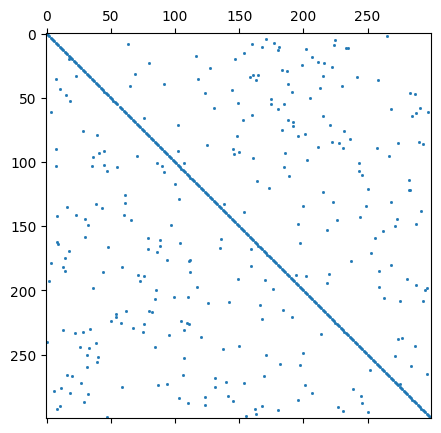

In [10]:
#REAL Markov matrix
M_mat0 = Markov_np(ys_fixed, sample)

#sanity check of Markov matrix
fig = plt.figure(figsize=(5, 5))
plt.spy(M_mat0, precision=0, marker=None, markersize=1, aspect='equal', origin='upper')

In [11]:
def matrix_original_cells(new_value, param_to_change):
     return Markov_np(Euler_np(change_param(new_value, param_to_change)), sample)

def mat_frobenius_norm(test_mat):
    return np.linalg.norm(M_mat0 - test_mat)

In [12]:
beta_values = np.linspace(.5, 3.5, num=13)
mat_beta = []
for beta_value in beta_values:
    mat_beta.append(mat_frobenius_norm(matrix_original_cells(beta_value, "beta")))



sigma_values = np.linspace(1, 20, num=39)
mat_sigma = []
for sigma_value in sigma_values:
    mat_sigma.append(mat_frobenius_norm(matrix_original_cells(sigma_value, "sigma")))

rho_values = np.linspace(20, 60, num= 31)
mat_rho = []
for rho_value in rho_values:
    mat_rho.append(mat_frobenius_norm(matrix_original_cells(rho_value, "rho")))


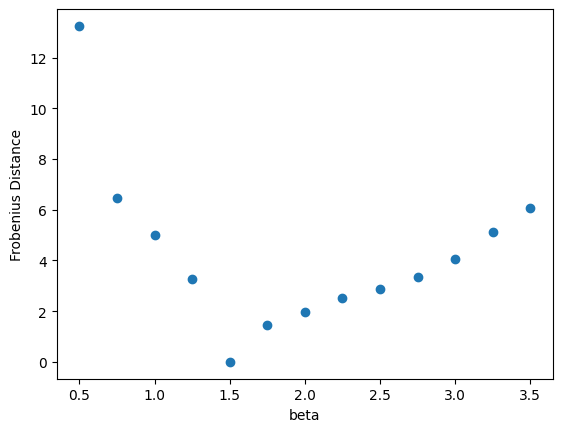

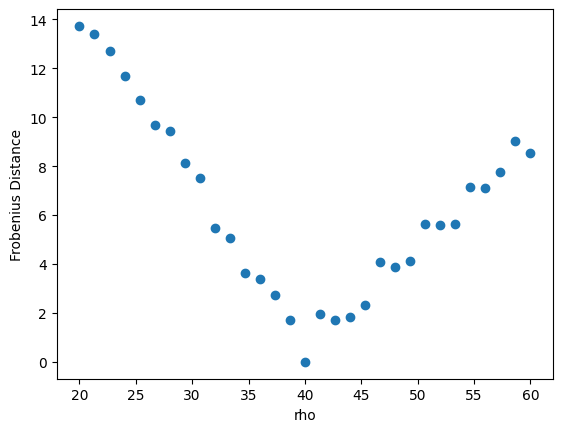

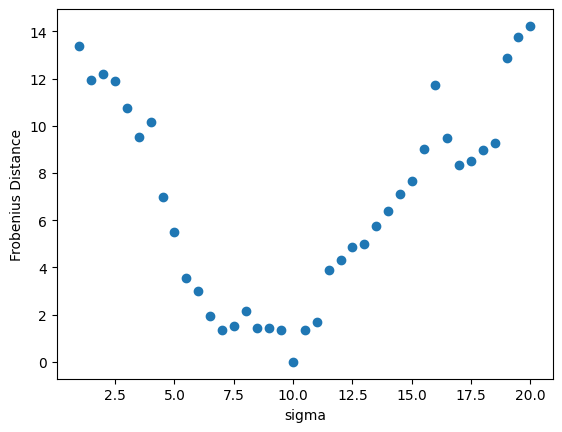

In [13]:


plt.scatter(beta_values, mat_beta)
plt.xlabel("beta")
plt.ylabel("Frobenius Distance")
plt.show()

plt.scatter(rho_values, mat_rho)
plt.xlabel("rho")
plt.ylabel("Frobenius Distance")
plt.show()

plt.scatter(sigma_values, mat_sigma)
plt.xlabel("sigma")
plt.ylabel("Frobenius Distance")
plt.show()